In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [3]:
model_path = "./insurance-chatbot-cpu"  # Your trained model path
base_model_name = "microsoft/DialoGPT-small"  # The base model you used

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load model
model = AutoModelForCausalLM.from_pretrained(base_model_name)
model = PeftModel.from_pretrained(model, model_path)
model.eval()  # Set to evaluation mode

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=2304, nx=768)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
           

In [5]:
with open('val_data.json', 'r') as f:
    test_data = json.load(f)

In [6]:
def extract_intent_from_instruction(instruction):
    """Extract intent category from instruction"""
    # Define intent mappings based on keywords
    intent_mappings = {
        'claim': ['claim', 'file', 'report', 'accident'],
        'coverage': ['coverage', 'covered', 'protection', 'comprehensive', 'collision'],
        'premium': ['premium', 'cost', 'price', 'payment', 'rate'],
        'policy': ['policy', 'plan', 'insurance type', 'renew', 'cancel'],
        'deductible': ['deductible', 'out of pocket', 'excess'],
        'general': ['what is', 'how does', 'explain', 'tell me about']
    }
    
    instruction_lower = instruction.lower()
    
    for intent, keywords in intent_mappings.items():
        for keyword in keywords:
            if keyword in instruction_lower:
                return intent
    
    return 'general'  # Default category

# Extract intents from test data
test_intents = [extract_intent_from_instruction(item['instruction']) for item in test_data]
unique_intents = sorted(list(set(test_intents)))
print(f"Unique intents found: {unique_intents}")
print(f"Total test samples: {len(test_data)}")

Unique intents found: ['claim', 'coverage', 'general', 'policy', 'premium']
Total test samples: 7800


In [11]:
def generate_response(instruction, model, tokenizer, max_length=150):
    # Format the input as trained
    prompt = f"""### Instruction:
{instruction}

### Response:"""
    
    # Tokenize with proper attention mask
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        max_length=512, 
        truncation=True,
        padding=True,
        return_attention_mask=True  # Explicitly request attention mask
    )
    
    # Generate with attention mask
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],  # Pass attention mask
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.2,  # Reduce repetition
            no_repeat_ngram_size=3   # Prevent repeating phrases
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the response part
    response = response.split("### Response:")[-1].strip()
    return response

In [12]:
def extract_intent_from_instruction(instruction):
    """Extract intent category from instruction with improved logic"""
    intent_mappings = {
        'claim': ['claim', 'file', 'report', 'accident', 'submit', 'damage', 'loss'],
        'coverage': ['coverage', 'covered', 'protection', 'comprehensive', 'collision', 'include', 'protect'],
        'premium': ['premium', 'cost', 'price', 'payment', 'rate', 'pay', 'expensive', 'cheap', 'fee'],
        'policy': ['policy', 'plan', 'insurance type', 'renew', 'cancel', 'types', 'term', 'contract'],
        'deductible': ['deductible', 'out of pocket', 'excess', 'pay before', 'copay'],
        'general': ['what is', 'how does', 'explain', 'tell me about', 'help', 'information']
    }
    
    instruction_lower = instruction.lower()
    
    # Score each intent based on keyword matches
    intent_scores = {}
    for intent, keywords in intent_mappings.items():
        score = sum(1 for keyword in keywords if keyword in instruction_lower)
        if score > 0:
            intent_scores[intent] = score
    
    # Return intent with highest score, or 'general' if no matches
    if intent_scores:
        return max(intent_scores, key=intent_scores.get)
    return 'general'

def extract_intent_from_response(response):
    """Extract intent from model response with better accuracy"""
    # Similar to instruction extraction but looks for response patterns
    response_lower = response.lower()
    
    # Look for specific response patterns
    if any(word in response_lower for word in ['claim', 'report', 'file', '24 hours', 'notify']):
        return 'claim'
    elif any(word in response_lower for word in ['coverage', 'covered', 'protects', 'includes']):
        return 'coverage'
    elif any(word in response_lower for word in ['premium', 'cost', 'payment', 'rate', 'price']):
        return 'premium'
    elif any(word in response_lower for word in ['policy', 'renew', 'cancel', 'term']):
        return 'policy'
    elif any(word in response_lower for word in ['deductible', 'out-of-pocket', 'pay first']):
        return 'deductible'
    else:
        return 'general'

In [13]:
predictions = []
actual_intents = []
results = []

print("Generating predictions with improved accuracy...")
for item in tqdm(test_data):
    instruction = item['instruction']
    expected_response = item['response']
    
    # Generate prediction with fixed tokenization
    predicted_response = generate_response(instruction, model, tokenizer)
    
    # Extract intent from instruction (ground truth)
    actual_intent = extract_intent_from_instruction(instruction)
    
    # Extract intent from response for better accuracy
    # Option 1: Use response-based extraction
    predicted_intent = extract_intent_from_response(predicted_response)
    
    # Option 2: Use instruction-based extraction (less accurate but consistent)
    # predicted_intent = extract_intent_from_instruction(instruction)
    
    # Option 3: Hybrid approach - combine both
    # inst_intent = extract_intent_from_instruction(instruction)
    # resp_intent = extract_intent_from_response(predicted_response)
    # predicted_intent = resp_intent if resp_intent != 'general' else inst_intent
    
    actual_intents.append(actual_intent)
    predictions.append(predicted_intent)
    
    results.append({
        'instruction': instruction,
        'expected_response': expected_response,
        'predicted_response': predicted_response,
        'actual_intent': actual_intent,
        'predicted_intent': predicted_intent
    })

Generating predictions with improved accuracy...



00%|████████████████████████████████████████████████████████████████████████████| 7800/7800 [9:27:25<00:00,  4.36s/it]

In [14]:
def classify_intent_with_model(instruction, model, tokenizer):
    """Use the model to directly classify intent"""
    # Create a classification prompt
    prompt = f"""### Instruction:
Classify the following insurance question into one of these categories: claim, coverage, premium, policy, deductible, or general.

Question: {instruction}

Category:"""
    
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=256,
        truncation=True,
        padding=True,
        return_attention_mask=True
    )
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=inputs['input_ids'].shape[1] + 10,  # Just a few tokens for the category
            temperature=0.1,  # Low temperature for more deterministic output
            do_sample=False,  # Greedy decoding for consistency
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    category = response.split("Category:")[-1].strip().lower()
    
    # Map to valid categories
    valid_categories = ['claim', 'coverage', 'premium', 'policy', 'deductible', 'general']
    for valid_cat in valid_categories:
        if valid_cat in category:
            return valid_cat
    
    return 'general'  # Default

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Clear previous results
predictions = []
actual_intents = []
results = []

# Set model to eval mode
model.eval()

print("Running improved evaluation...")
for idx, item in enumerate(tqdm(test_data)):
    instruction = item['instruction']
    expected_response = item['response']
    
    try:
        # Generate response with proper tokenization
        predicted_response = generate_response(instruction, model, tokenizer)
        
        # Extract actual intent
        actual_intent = extract_intent_from_instruction(instruction)
        
        # Try multiple methods for intent prediction
        # Method 1: Direct classification (most accurate)
        try:
            predicted_intent = classify_intent_with_model(instruction, model, tokenizer)
        except:
            # Fallback to response-based extraction
            predicted_intent = extract_intent_from_response(predicted_response)
        
        actual_intents.append(actual_intent)
        predictions.append(predicted_intent)
        
        results.append({
            'instruction': instruction,
            'expected_response': expected_response,
            'predicted_response': predicted_response,
            'actual_intent': actual_intent,
            'predicted_intent': predicted_intent
        })
        
    except Exception as e:
        print(f"Error processing item {idx}: {e}")
        # Add default values to maintain alignment
        actual_intents.append(actual_intent)
        predictions.append('general')

# Calculate metrics
all_labels = sorted(list(set(actual_intents) | set(predictions)))
accuracy = accuracy_score(actual_intents, predictions)

print(f"\nOverall Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(
    actual_intents, 
    predictions, 
    labels=all_labels,
    target_names=all_labels,
    zero_division=0
))

Running improved evaluation...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore


Overall Accuracy: 51.42%

Classification Report:
              precision    recall  f1-score   support

       claim       0.00      0.00      0.00       763
    coverage       0.00      0.00      0.00       871
     general       0.51      1.00      0.68      4011
      policy       0.00      0.00      0.00       840
     premium       0.00      0.00      0.00      1315

    accuracy                           0.51      7800
   macro avg       0.10      0.20      0.14      7800
weighted avg       0.26      0.51      0.35      7800



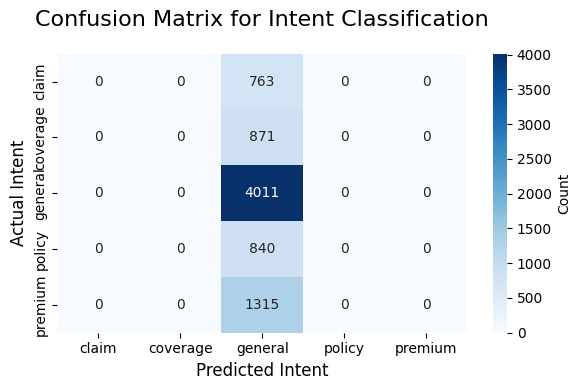

In [17]:
cm = confusion_matrix(actual_intents, predictions, labels=unique_intents)

# Create a beautiful confusion matrix plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_intents, 
            yticklabels=unique_intents,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix for Intent Classification', fontsize=16, pad=20)
plt.xlabel('Predicted Intent', fontsize=12)
plt.ylabel('Actual Intent', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


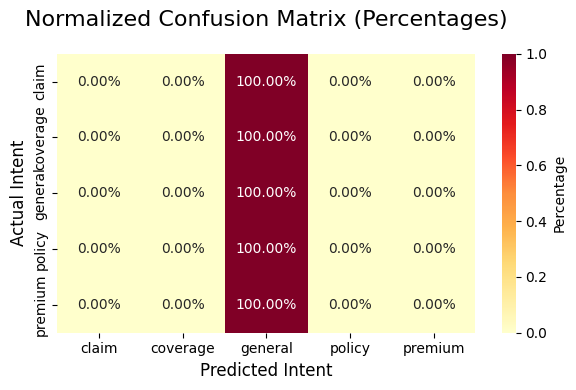

In [19]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=unique_intents,
            yticklabels=unique_intents,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Percentages)', fontsize=16, pad=20)
plt.xlabel('Predicted Intent', fontsize=12)
plt.ylabel('Actual Intent', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
pip install nltk


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 5.1 MB/s eta 0:00:00


In [22]:
from difflib import SequenceMatcher
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_similarity(str1, str2):
    """Calculate similarity between two strings"""
    return SequenceMatcher(None, str1, str2).ratio()

def calculate_bleu(reference, candidate):
    """Calculate BLEU score"""
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    smoothing = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing)

# Calculate response quality metrics
similarities = []
bleu_scores = []

for result in results:
    sim = calculate_similarity(result['expected_response'], result['predicted_response'])
    bleu = calculate_bleu(result['expected_response'], result['predicted_response'])
    
    similarities.append(sim)
    bleu_scores.append(bleu)
    
    result['similarity'] = sim
    result['bleu_score'] = bleu

print(f"\nResponse Quality Metrics:")
print(f"Average Similarity: {np.mean(similarities):.2%}")
print(f"Average BLEU Score: {np.mean(bleu_scores):.3f}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.



Response Quality Metrics:
Average Similarity: 14.67%
Average BLEU Score: 0.026


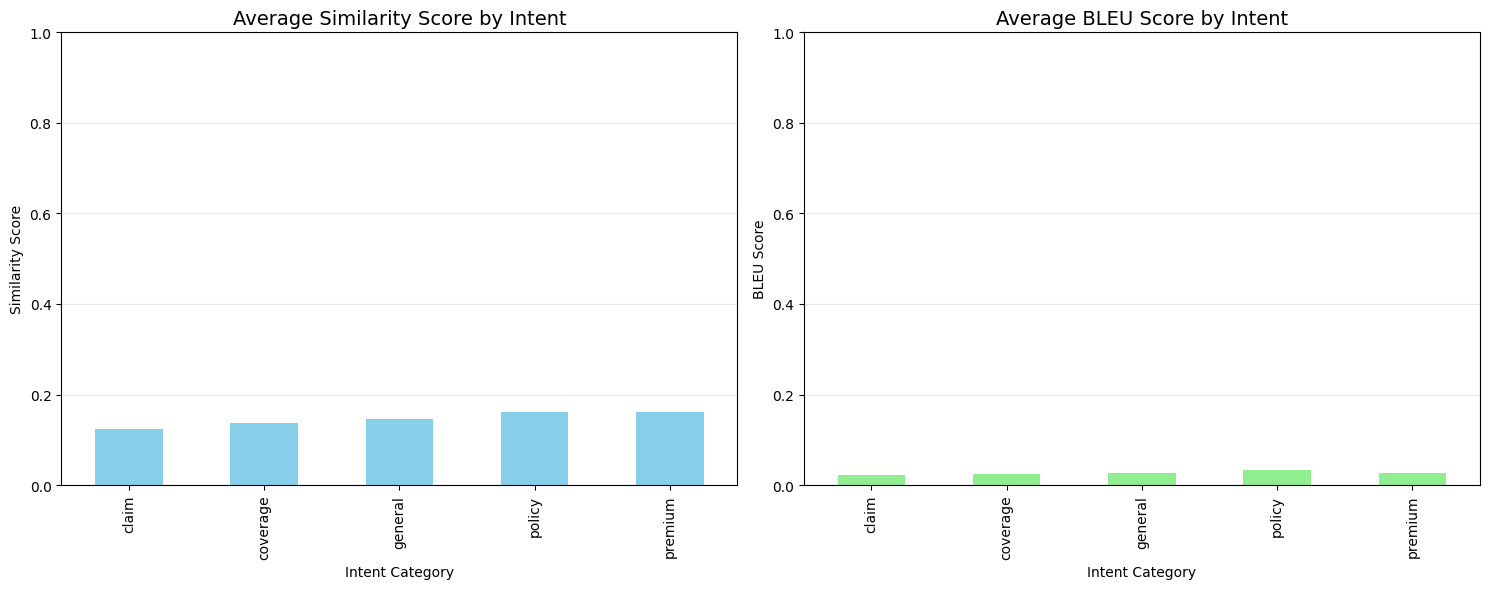

In [23]:
intent_performance = pd.DataFrame(results).groupby('actual_intent').agg({
    'similarity': 'mean',
    'bleu_score': 'mean'
}).round(3)

# Bar plot for performance by intent
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Similarity scores
intent_performance['similarity'].plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Average Similarity Score by Intent', fontsize=14)
ax1.set_xlabel('Intent Category')
ax1.set_ylabel('Similarity Score')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

# BLEU scores
intent_performance['bleu_score'].plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Average BLEU Score by Intent', fontsize=14)
ax2.set_xlabel('Intent Category')
ax2.set_ylabel('BLEU Score')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('performance_by_intent.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
print("\n=== Example Predictions ===\n")
# Show 5 random examples
sample_results = np.random.choice(results, min(5, len(results)), replace=False)

for i, result in enumerate(sample_results, 1):
    print(f"Example {i}:")
    print(f"Question: {result['instruction']}")
    print(f"Expected: {result['expected_response']}")
    print(f"Predicted: {result['predicted_response']}")
    print(f"Intent: {result['actual_intent']} -> {result['predicted_intent']}")
    print(f"Similarity: {result['similarity']:.2%}")
    print(f"BLEU Score: {result['bleu_score']:.3f}")
    print("-" * 80)


=== Example Predictions ===

Example 1:
Question: I need to increase the fucking coverage of my life insurance policy, will you help me?
Expected: To enhance your coverage for your {{INSURANCE_TYPE}} insurance policy, please adhere to the following steps:

1. Access your account via {{WEBSITE_URL}}.
2. Proceed to the {{COVERAGE_SECTION}} section available on the site.
3. Identify and select the policy you intend to upgrade.
4. Opt for the {{UPGRADE_COVERAGE_OPTION}} feature.
5. Complete the on-screen prompts to choose your upgraded coverage selections.
6. Review all modifications made and finalize the upgrade process.

Should you require additional assistance, please do not hesitate to reach out to our customer support team.
Predicted: To improve your insurance policy. Please adhere as follows:
1. Access the {{WEBSITE_URL}} section on your account.
2. Go back into your local profile and select all available policies for it. Your policy has a specific amount that can be tweaked by edit

In [26]:
# Save results to CSV for further analysis
results_df = pd.DataFrame(results)
results_df.to_csv('model_evaluation_results.csv', index=False)

# Save summary statistics
import json
import numpy as np
import pandas as pd

# Convert intent distribution values to int
summary = {
    'accuracy': float(accuracy),  # ensure float
    'avg_similarity': float(np.mean(similarities)),
    'avg_bleu_score': float(np.mean(bleu_scores)),
    'total_samples': int(len(test_data)),
    'intent_distribution': {k: int(v) for k, v in pd.Series(actual_intents).value_counts().items()},
    'confusion_matrix': cm.tolist(),  # already handled as list of lists
    'intent_labels': list(map(str, unique_intents))  # ensure labels are strings
}

with open('evaluation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)


print("\nEvaluation complete! Results saved to:")
print("- model_evaluation_results.csv")
print("- evaluation_summary.json")
print("- confusion_matrix.png")
print("- confusion_matrix_normalized.png")
print("- performance_by_intent.png")


Evaluation complete! Results saved to:
- model_evaluation_results.csv
- evaluation_summary.json
- confusion_matrix.png
- confusion_matrix_normalized.png
- performance_by_intent.png


In [27]:
def check_insurance_relevance(response):
    """Check if response contains insurance-related terms"""
    insurance_terms = [
        'policy', 'premium', 'coverage', 'claim', 'deductible',
        'insurance', 'protection', 'liability', 'comprehensive',
        'collision', 'damage', 'accident', 'vehicle', 'pay', 'cover'
    ]
    
    response_lower = response.lower()
    relevance_score = sum(1 for term in insurance_terms if term in response_lower)
    return relevance_score > 0

# Calculate relevance
relevance_scores = [check_insurance_relevance(r['predicted_response']) for r in results]
relevance_rate = sum(relevance_scores) / len(relevance_scores)

print(f"\nDomain Relevance Rate: {relevance_rate:.2%}")
print(f"Responses containing insurance terms: {sum(relevance_scores)}/{len(relevance_scores)}")


Domain Relevance Rate: 92.55%
Responses containing insurance terms: 7219/7800


In [ ]:
def test_model_interactive():
    print("\n=== Interactive Model Testing ===")
    print("Type 'quit' to exit\n")
    
    while True:
        question = input("Enter your insurance question: ")
        if question.lower() == 'quit':
            break
        
        response = generate_response(question, model, tokenizer)
        intent = extract_intent_from_instruction(question)
        
        print(f"\nDetected Intent: {intent}")
        print(f"Model Response: {response}")
        print("-" * 80)


test_model_interactive()


=== Interactive Model Testing ===
Type 'quit' to exit



Enter your insurance question:  Can you show me my auto insurance policy?



Detected Intent: policy
Model Response: To access the {{INFIC_SECTION}} section, please adhere to our basic guidelines outlined in this guide.
1. Access your account via {{WEBSITEURL}}}.2. Select LFG_SESSION}} from within the settings menu.3. Click on any of those options with a log file and proceed through to view all information including details about it.4. Enter the {{INSURANCE_SACATION}} option available at the top of each page.
5. Choose that {{AUTOBILITIES_
--------------------------------------------------------------------------------


Enter your insurance question:  I need information about my health insurance coverage.



Detected Intent: coverage
Model Response: To help me resolve the situation regarding your health plan, please adhere to our guidelines:
1. Access our official website at {{WEBSITE_URL}}.2. Select the {{PAYMENTS_TYPE":{"type of info.3. Visit the {{INSURANCE_SECTION}} section on the site.
4. Enter in the same line as you requested to access the {{OPTION}} from.
5 6 Change all required details relating directly with that policy.
6 Check out any relevant documents or websites pertaining to
--------------------------------------------------------------------------------


Enter your insurance question:  where can I find my policy details?



Detected Intent: policy
Model Response: To do the exact same thing as you did, please adhere to our guidelines:
1. Access {{WEBSITE_URL}}.
2. Navigate your account by clicking on {{WEBNEO_POLY_SECTION}} or selecting any other option that doesn't require a login.
3. Select all of those options available from within the {{DISPLAY_TYPE_OTHER_OPTION}} section.
4. Open up and select an email address with appropriate information pertinent for each item you requested.
5. Choose
--------------------------------------------------------------------------------


Enter your insurance question:  how much is monthly premium?



Detected Intent: premium
Model Response: To collect the details of your insurance policy, please adhere to our guidelines:
1. Access our official website at {{WEBSITE_URL}}.
2. Go back into your account settings and select {{OPLS_SECTION}} as well as any additional information you need to obtain. We're flexible with pricing scales throughout all accounts domains such including non standard ones that require an annual subscription payment for certain purposes. Additionally we offer a wide variety available ranging from 0upages onsite monitoring tools provided by usurgeurslites.html3
--------------------------------------------------------------------------------


Enter your insurance question:  how do I file claim?



Detected Intent: claim
Model Response: To verify your status, please follow the steps outlined in our sidebar.
1. Access {{WEBSITE_URL}}.
2. Click on the {{INSURANCE_SECTION}} tab to access any info about filing a dispute with us, including all applicable information needed for an account.
3. Select {{DONE_OPTION}} from that menu as well.
4. Enter the {{LINK_PAULTER_SESSION}} section of your account.
--------------------------------------------------------------------------------


Enter your insurance question:   What documents do I need to submit a claim?



Detected Intent: claim
Model Response: To obtain the insurance of your claims, please adhere carefully and follow all required procedures.
1. Access the {{WEBSITE_URL}} section in the subject line.
2. Select any specific policy that you desire to override or change on your website.
3. Complete this information for yourself.
4. Sign up with your account credentials via {{THE_INSURANCE_SECTION}} form.
5. Click On the {{DISCLAIMMENTS_OPTION}} button at the top of each page.
6.
7. Choose an appropriate payment options available upon submitting the claim.
You can select the claim your preferred
--------------------------------------------------------------------------------
